In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Read Data
df = pd.read_csv('reddit_train.csv')

# Pre- processing 
tfidf_vectorizer = TfidfVectorizer(max_df=0.1,smooth_idf=False, 
                   stop_words=['english','http','www'],sublinear_tf=True, tokenizer=None, use_idf=True)
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['comments'])

# Target labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['subreddits'])
y_train = df['label'].to_numpy()

# Feature reduction
select_best = SelectPercentile(chi2, percentile=23)
X_train = select_best.fit_transform(tfidf, y_train)

# Model initilize
models = [
       LogisticRegression(C=25,solver='lbfgs', multi_class='multinomial',  max_iter=1000),
       LinearSVC(C=0.30),
       MultinomialNB(alpha = 0.08),
       MLPClassifier(hidden_layer_sizes=(95,),alpha=0.00005, batch_size=200, learning_rate='invscaling',
                    learning_rate_init=0.0009, power_t=0.9, max_iter=100, shuffle=True,
                    tol=0.1, validation_fraction=0.8, epsilon=1e-8, n_iter_no_change=2)
]

# Cross validation
Cross_validation_fold = 5
cv_df = pd.DataFrame(index=range(Cross_validation_fold * len(models)))
entries = []
for model in models:
  model_name = type(model).__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy',n_jobs=-1, cv=Cross_validation_fold)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_index', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.585143
LogisticRegression    0.545043
MLPClassifier         0.587129
MultinomialNB         0.598443
Name: accuracy, dtype: float64

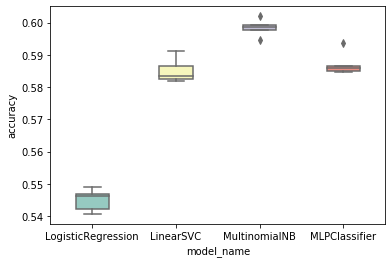

In [3]:
import seaborn as sns
ax = sns.boxplot(x="model_name", y="accuracy", data=cv_df,width=0.4, dodge=True, fliersize=5, linewidth=1.5, palette="Set3")
#ax.figure.savefig("comparision.png")